# What if we increase the sim time?

In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    update_mask = t.logical_and(greater_zero_mask, t.logical_and(unequal_mask, sml_eq_two_mask))
    
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [13]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in tqdm(range(100)):
        #print(f"-------- MCS {i} --------------")
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - 0.)**2 
    print(f"loss: {loss}")
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, loss, mean_distance

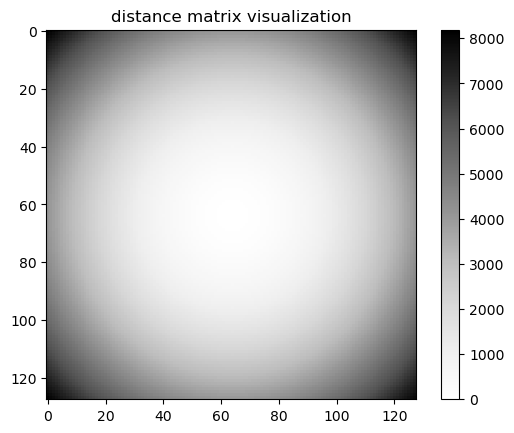

In [11]:
init_state = t.zeros(1000,128,128, device=device)
init_state[:,64,64] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0].cpu(), return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix).to(device)
fig = plt.imshow(dist_matrix, cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

In [14]:
temps = t.linspace(1, 35, 35)
target_vol = 0.

losses = []
grads = []
mean_distances = []
std_distances = []
for temp in temps:
    temp.requires_grad_()
    batch = init_state.detach().clone()
    new_temp, grad, loss, mean_distance = step(batch, dist_matrix_t, temp, target_vol, eta=1)
    losses.append(loss.detach().cpu().numpy())
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


temperature: 1.0, mean distance: 0.1515
loss: 0.02295225
gradient: 0.33482420444488525


 32%|███▏      | 32/100 [00:16<00:34,  1.97it/s]


KeyboardInterrupt: 

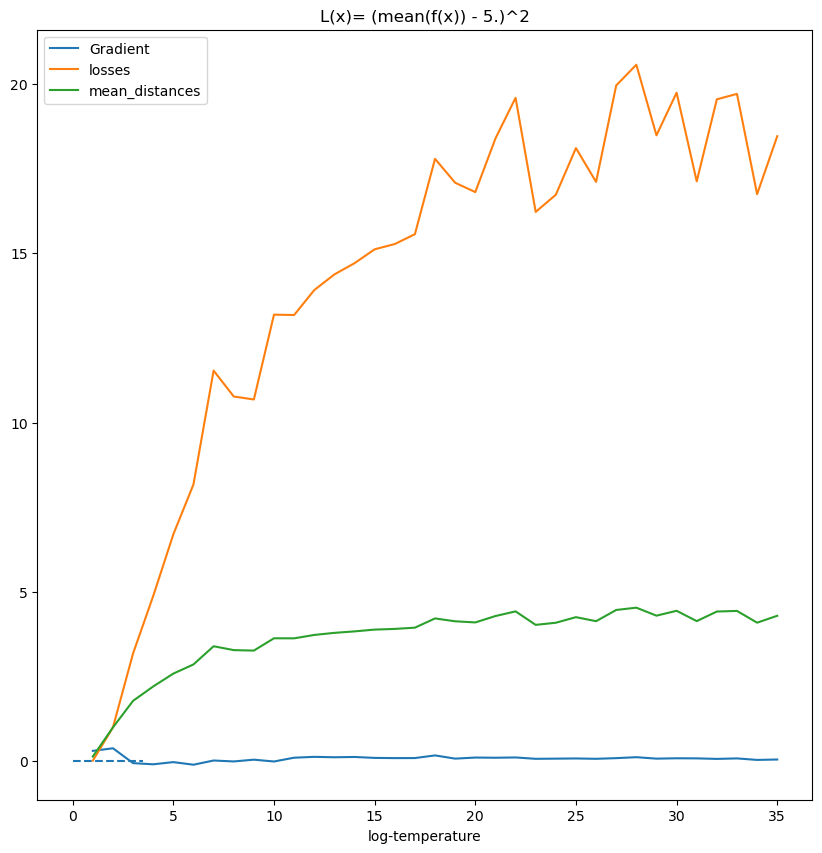

In [9]:
x_vals = temps.cpu().numpy()

plt.figure(figsize=(10,10))
plt.plot(x_vals,grads, label="Gradient")
plt.hlines([0.], xmin=0, xmax=3.5, linestyles="dashed")
plt.plot(x_vals, np.stack(losses, axis=0), label="losses")
plt.plot(x_vals, np.stack(mean_distances, axis=0), label="mean_distances")
plt.title("L(x)= (mean(f(x)) - 5.)^2")
plt.xlabel("log-temperature")
plt.legend()
